<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/single_input/Analisis_CNN_2_gamma_others.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#cargamos librerias 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import tensorflow as tf
import glob 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import matplotlib as mplt

Vamos a automaticar el preoceso de :
* Crear un modelo
* Cargar los datos necesarios 
* Formatear los datos bien
* Pasarle los datos a la red 
* compilarla y entrenarla 
* finalmente guardar los progresos asi como las funciones los y acuracy


IMPORTANTE:

Solo vamos a tomar una cantidad mas o menos equivalente de datos para cada entrenamiento, porque sino pera esto

(Es posible que tenga problemas con los de masximo peso)

In [ ]:
import keras

In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.models.Sequential?

In [ ]:
#usamos la funcion crear modelo que ha usado Rrodigo en su tfg
 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
 
def create_model(padding='same',stride=2,pool=2,filters=64,kernel=5,hidden_layers=2,neurons=20,optimizer='Adadelta',
                 learn_rate=0.001, init_mode='glorot_normal', activation='relu', dropout_rate=0.4,
                 weight_constraint=None,weight_regularizer=None, batchn=0,conv=2, n_filters=2,numClasses=2):#parameters here are default
 
    # initialize the model
    model = Sequential()                                                                       
 
    for i in range (conv):
        num=int(round(filters*(2**(i-1))))
        for i in range (n_filters):
              model.add(Conv2D(num, kernel, padding=padding,activation=activation,kernel_initializer=init_mode,kernel_constraint=weight_constraint,kernel_regularizer=weight_regularizer))
        model.add(MaxPooling2D(pool_size=(pool, pool), strides=(stride, stride)))
        # model.add(Dropout(dropout_rate))
    # define the first FC => ACTIVATION layers
    model.add(Flatten())
    if (batchn==1):
        model.add(BatchNormalization())     
    model.add(Dropout(dropout_rate)) 
    for i in range(hidden_layers):
        model.add(Dense(neurons,kernel_initializer=init_mode,  activation=activation,kernel_regularizer=weight_regularizer)) 
        if (batchn==1):
            model.add(BatchNormalization())    #, use_bias=False
        model.add(Dropout(dropout_rate)) 
    # lastly, define the soft-max classifier
    model.add(Dense(numClasses, activation='softmax'))
 
    if (optimizer=='SGD'):
        optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    elif (optimizer=='RMS'):
        optimizer=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    elif (optimizer=='Adagrad'):
        optimizer=keras.optimizers.Adagrad(learning_rate=0.01)
    elif (optimizer=='Adadelta'):
        optimizer=keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
    elif (optimizer=='Adamax'):
        optimizer=keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
    elif (optimizer=='Nadam'):
        optimizer=keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
    elif (optimizer=='Adam'):
        optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
 
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])   #ponemos esto en lugar de solo accuraci porque nos da un error al cargar el modelo de nuevo y hacer. Evaluate()           
 
    return model

In [ ]:
npy_dir="/content/drive/MyDrive/TFG arturo/npy archivos"
direct_hist="/content/drive/MyDrive/TFG arturo/stats_1/clasif_CNN_1/"
#lo mejor va a ser tener cargadas unas cuantas de gamma y darselo conforme lo requiera 
 
nombre_aux="gamma_"+str(1)+".npy"
datos_gamma=np.load(os.path.join(npy_dir,nombre_aux))
tamaño_un_gamma=datos_gamma.nbytes #os.stat("/content/drive/MyDrive/TFG arturo/npy archivos/gamma_1.npy").st_size
elementos=["helium"]
 
for j in range(1,6):
  nombre_aux="gamma_"+str(j)+".npy"
  load_aux=np.load(os.path.join(npy_dir,nombre_aux))
  datos_gamma=np.concatenate((datos_gamma,load_aux),axis=0)
 
 
for i in elementos:
  #primero cargamos los datos necesarios
 
  datos_elemento=np.load(os.path.join(npy_dir,i+".npy"))
  
  len_ds=int(round(datos_elemento.shape[0]/2))
  datos_elemento=datos_elemento[:len_ds]
  #vamos a cargar de datos los mismo pero de gammas
  datos_gamma_aux=datos_gamma[:len_ds].copy()
  datos=np.concatenate((datos_elemento,datos_gamma_aux),axis=0)
 
  labels0=np.zeros(len_ds)
  labels1=np.ones(len_ds)
  labels=np.concatenate((labels0,labels1),axis=0)
  X_train_aux,X_test_aux,y_train,y_test=train_test_split(datos,labels,test_size=0.20, random_state=3)
  X_train=np.expand_dims(X_train_aux,axis=-1)
  X_test=np.expand_dims(X_test_aux,axis=-1)
  data_train=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(128)
  data_train=data_train.prefetch(1)
  data_test=tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(128)
  data_test=data_test.prefetch(1) 
  shape=[128,55,93,1]
  model=create_model()
  model.build(shape) 
  history=model.fit(data_train, epochs=60,batch_size=128, validation_data=data_test)  
  
  #vamos a borrar lo que no necesitamos
  del data_train, datos_elemento, datos, datos_gamma_aux
  del X_train, X_train_aux, y_train
  model.save(direct_hist+"modelo_"+i+".h5")
  plt.figure(figsize=(12,12))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss, gamma vs.'+i)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.savefig(direct_hist+"loss_train_gamma_vs_"+i+".png")
  plt.close()
  plt.figure(figsize=(12,12))
  plt.plot(history.history['sparse_categorical_accuracy'])
  plt.plot(history.history['val_sparse_categorical_accuracy'])
  plt.title('Model accuracy, gamma vs.'+i)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.savefig(direct_hist+"acc_train_gamma_vs_"+i+".png")
  plt.close()
 
  val_loss, val_acc = model.evaluate(data_test)
  y_pred = model.predict_classes(X_test)
  conf_aux=confusion_matrix(y_test, y_pred)
  report_aux=classification_report(y_test, y_pred)
  with open(direct_hist+i+"_report.txt","w") as report:
    report.write("val_loss: "+str(val_loss)+"\t"+"val_acc: "+str(val_acc)+"\n")
    report.write(str(conf_aux)+"\n"+str(report_aux)+"\n")
    report.close()
 
  plt.figure(figsize=(15,15))
  y_percent=model.predict(X_test)
  y_percent=y_percent[:,0][y_test!=y_pred]
  y_pred_mal=y_pred[y_test!=y_pred]
  errores=X_test_aux[y_test!=y_pred]
  if (errores.shape[0]>=16):
    rango=range(1,17)
    asd=4 
    asd2=4
    abortar=False
 
  elif errores.shape[0]>=9:
    rango=range(1,10)
    asd=3
    asd2=3
    abortar=False
 
  elif errores.shape[0]>=4:
    rango=range(1,5)
    asd=2
    asd2=2
    abortar=False
  elif errores.shape[0]>=2:
    rango=range(1,3)
    asd=2     
    asd2=1
    abortar=False
  elif errores.shape[0]>=1:
    rango=range(1,2)
    asd=1
    asd2=1
    abortar=False 
  else:
    abortar=True 
  if not abortar:
    for k in rango:
      plt.subplot(asd,asd2,k)
      num_mal=y_pred_mal[k-1]
      if num_mal==1 :
        nombre_bien=i
        nombre_mal="gamma"
        prob=round((1-y_percent[k-1])*100,4)
      elif num_mal==0:
        nombre_bien="gamma"
        nombre_mal=i
        prob=round((y_percent[k-1])*100,4)
      plt.title("Es un "+nombre_bien+" pero \n ha dicho con un "+str(prob)+"% \n"+"que era un "+nombre_mal, fontsize=14)
      plt.imshow(errores[k-1])
    plt.tight_layout()
    plt.savefig(direct_hist+"errores_"+i+".png")
    plt.close()

Epoch 1/60

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

124/124 [==============================] - 8s 67ms/step - loss: 0.4109 - sparse_categorical_accuracy: 0.8080 - val_loss: 0.0597 - val_sparse_categorical_accuracy: 0.9801
Epoch 2/60
124/124 [==============================] - 8s 62ms/step - loss: 0.0619 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.0028 - val_sparse_categorical_accuracy: 0.9995
Epoch 3/60
124/124 [==============================] - 8s 63ms/step - loss: 0.0284 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.0036 - val_s

KeyError: ignored

<Figure size 864x864 with 0 Axes>

In [ ]:
val_loss, val_acc = model.evaluate(data_test)
y_pred = model.predict_classes(X_test)
conf_aux=confusion_matrix(y_test, y_pred)
report_aux=classification_report(y_test, y_pred)
with open(direct_hist+i+"_report.txt","w") as report:
  report.write("val_loss: "+str(val_loss)+"\t"+"val_acc: "+str(val_acc)+"\n")
  report.write(str(conf_aux)+"\n"+str(report_aux)+"\n")
  report.close()

plt.figure(figsize=(15,15))
y_percent=model.predict(X_test)
y_percent=y_percent[:,0][y_test!=y_pred]
y_pred_mal=y_pred[y_test!=y_pred]
errores=X_test_aux[y_test!=y_pred]
if (errores.shape[0]>=16):
  rango=range(1,17)
  asd=4 
  asd2=4
  abortar=False

elif errores.shape[0]>=9:
  rango=range(1,10)
  asd=3
  asd2=3
  abortar=False

elif errores.shape[0]>=4:
  rango=range(1,5)
  asd=2
  asd2=2
  abortar=False
elif errores.shape[0]>=2:
  rango=range(1,3)
  asd=2     
  asd2=1
  abortar=False
elif errores.shape[0]>=1:
  rango=range(1,2)
  asd=1
  asd2=1
  abortar=False 
else:
  abortar=True 
if not abortar:
  for k in rango:
    plt.subplot(asd,asd2,k)
    num_mal=y_pred_mal[k-1]
    if num_mal==1 :
      nombre_bien=i
      nombre_mal="gamma"
      prob=round((1-y_percent[k-1])*100,4)
    elif num_mal==0:
      nombre_bien="gamma"
      nombre_mal=i
      prob=round((y_percent[k-1])*100,4)
    plt.title("Es un "+nombre_bien+" pero \n ha dicho con un "+str(prob)+"% \n"+"que era un "+nombre_mal, fontsize=14)
    plt.imshow(errores[k-1])
  plt.tight_layout()
  plt.savefig(direct_hist+"errores_"+i+".png")
  plt.close()

31/31 [==============================] - 1s 19ms/step - loss: 7.7094e-04 - sparse_categorical_accuracy: 0.9997
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
 
direct_hist="/content/drive/MyDrive/TFG arturo/stats_1/clasif_CNN_1/"
mod=tf.keras.models.load_model(direct_hist+"modelo_nitrogen.h5")

In [ ]:
 
npy_dir="/content/drive/MyDrive/TFG arturo/npy archivos"
direct_hist="/content/drive/MyDrive/TFG arturo/stats_1/clasif_CNN_1/"
#lo mejor va a ser tener cargadas unas cuantas de gamma y darselo conforme lo requiera 
 
nombre_aux="gamma_"+str(1)+".npy"
datos_gamma=np.load(os.path.join(npy_dir,nombre_aux))
tamaño_un_gamma=datos_gamma.nbytes #os.stat("/content/drive/MyDrive/TFG arturo/npy archivos/gamma_1.npy").st_size
elementos=["nitrogen"]#["helium","silicon","iron","electron","proton","nitrogen"]
 
for j in range(1,6):
  nombre_aux="gamma_"+str(j)+".npy"
  load_aux=np.load(os.path.join(npy_dir,nombre_aux))
  datos_gamma=np.concatenate((datos_gamma,load_aux),axis=0)
 
 
for i in elementos:
  #primero cargamos los datos necesarios
 
  datos_elemento=np.load(os.path.join(npy_dir,i+".npy"))
  len_ds=datos_elemento.shape[0]
  #vamos a cargar de datos los mismo pero de gammas
  datos_gamma_aux=datos_gamma[:len_ds].copy()
  datos=np.concatenate((datos_elemento,datos_gamma_aux),axis=0)
 
  labels0=np.zeros(len_ds)
  labels1=np.ones(len_ds)
  labels=np.concatenate((labels0,labels1),axis=0)
  X_train_aux,X_test_aux,y_train,y_test=train_test_split(datos,labels,test_size=0.20, random_state=3)
  #X_train=np.expand_dims(X_train_aux,axis=-1)
  X_test=np.expand_dims(X_test_aux,axis=-1)
  #data_train=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(128)
  #data_train=data_train.prefetch(1)
  data_test=tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(128)
  data_test=data_test.prefetch(1) 
  shape=[128,55,93,1]
  #model=create_model()
  #model.build(shape) 
  #history=model.fit(data_train, epochs=60,batch_size=128, validation_data=data_test)  
  model=tf.keras.models.load_model(direct_hist+"modelo_"+i+".h5")
  #model.save(direct_hist+"modelo_"+i+".h5")
  
  print(i)
  val_loss, val_acc = model.evaluate(data_test)
  print(str(val_acc))
  val_loss, val_acc =model.evaluate(data_test)
  print(str(val_acc))
  
  y_pred = model.predict_classes(X_test)
  conf_aux=confusion_matrix(y_test, y_pred)
  a=y_test.shape[0]
  b=y_test[y_test != y_pred]
  print("test_acc bien: " +str(1-b.shape[0]/a))
  print(conf_aux)
  report_aux=classification_report(y_test, y_pred)
  with open(direct_hist+i+"_report2.txt","w") as report:
    report.write(i)
    report.write(str(val_acc))
    report.write("test_acc bien: " +str(1-b.shape[0]/a))
    report.write(str(conf_aux))
    report.write(str(conf_aux)+"\n"+str(report_aux)+"\n")
    report.close()
"""
with open(direct_hist+i+"_report.txt","w") as report:
    report.write("val_loss: "+str(val_loss)+"\t"+"val_acc: "+str(val_acc)+"\n")
    report.write(str(conf_aux)+"\n"+str(report_aux)+"\n")
    report.close()
 
  plt.figure(figsize=(15,15))
  y_percent=model.predict(X_test)
  y_percent=y_percent[:,0][y_test!=y_pred]
  y_pred_mal=y_pred[y_test!=y_pred]
  errores=X_test_aux[y_test!=y_pred]
  if (errores.shape[0]>=16):
    rango=range(1,17)
    asd=4 
    asd2=4
    abortar=False
 
  elif errores.shape[0]>=9:
    rango=range(1,10)
    asd=3
    asd2=3
    abortar=False
 
  elif errores.shape[0]>=4:
    rango=range(1,5)
    asd=2
    asd2=2
    abortar=False
  elif errores.shape[0]>=2:
    rango=range(1,3)
    asd=2     
    asd2=1
    abortar=False
  elif errores.shape[0]>=1:
    rango=range(1,2)
    asd=1
    asd2=1
    abortar=False 
  else:
    abortar=True
 
  if not abortar:
    for k in rango:
      plt.subplot(asd,asd2,k)
      num_mal=y_pred_mal[k-1]
      if num_mal==1 :
        nombre_bien=i
        nombre_mal="gamma"
        prob=round((1-y_percent[k-1])*100,4)
      elif num_mal==0:
        nombre_bien="gamma"
        nombre_mal=i
        prob=round((y_percent[k-1])*100,4)
      plt.title("Es un "+nombre_bien+" pero \n ha dicho con un "+str(prob)+"% \n"+"que era un "+nombre_mal, fontsize=14)
      plt.imshow(errores[k-1])
    plt.tight_layout()
    plt.savefig(direct_hist+"errores_"+i+".png")
    plt.close()
"""

nitrogen
35/35 [==============================] - 1s 18ms/step - loss: 0.0130 - accuracy: 0.5029
0.5028532147407532
35/35 [==============================] - 1s 16ms/step - loss: 0.0130 - accuracy: 0.5029
0.5028532147407532
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
test_acc bien: 0.9993152248345126
[[2201    1]
 [   2 2177]]


'\nwith open(direct_hist+i+"_report.txt","w") as report:\n   report.write("val_loss: "+str(val_loss)+"\t"+"val_acc: "+str(val_acc)+"\n")\n   report.write(str(conf_aux)+"\n"+str(report_aux)+"\n")\n   report.close()\n\n plt.figure(figsize=(15,15))\n y_percent=model.predict(X_test)\n y_percent=y_percent[:,0][y_test!=y_pred]\n y_pred_mal=y_pred[y_test!=y_pred]\n errores=X_test_aux[y_test!=y_pred]\n if (errores.shape[0]>=16):\n   rango=range(1,17)\n   asd=4 \n   asd2=4\n   abortar=False\n\n elif errores.shape[0]>=9:\n   rango=range(1,10)\n   asd=3\n   asd2=3\n   abortar=False\n\n elif errores.shape[0]>=4:\n   rango=range(1,5)\n   asd=2\n   asd2=2\n   abortar=False\n elif errores.shape[0]>=2:\n   rango=range(1,3)\n   asd=2     \n   asd2=1\n   abortar=False\n elif errores.shape[0]>=1:\n   rango=range(1,2)\n   asd=1\n   asd2=1\n   abortar=False \n else:\n   abortar=True\n\n if not abortar:\n   for k in rango:\n     plt.subplot(asd,asd2,k)\n     num_mal=y_pred_mal[k-1]\n     if num_mal==1 :\n  

In [ ]:
#para el proton lo hacemos en dos
npy_dir="/content/drive/MyDrive/TFG arturo/npy archivos"
direct_hist="/content/drive/MyDrive/TFG arturo/stats_1/clasif_CNN_1/"
#lo mejor va a ser tener cargadas unas cuantas de gamma y darselo conforme lo requiera 
 
nombre_aux="gamma_"+str(1)+".npy"
datos_gamma=np.load(os.path.join(npy_dir,nombre_aux))
tamaño_un_gamma=datos_gamma.nbytes #os.stat("/content/drive/MyDrive/TFG arturo/npy archivos/gamma_1.npy").st_size
elementos=["proton"]
 
for j in range(6,10):
  nombre_aux="gamma_"+str(j)+".npy"
  load_aux=np.load(os.path.join(npy_dir,nombre_aux))
  datos_gamma=np.concatenate((datos_gamma,load_aux),axis=0)
 
 
for i in elementos:
  #primero cargamos los datos necesarios
 
  datos_elemento=np.load(os.path.join(npy_dir,i+".npy"))
  
  len_ds=int(round(datos_elemento.shape[0]/2))
  datos_elemento=datos_elemento[len_ds:]
  #vamos a cargar de datos los mismo pero de gammas
  datos_gamma_aux=datos_gamma[:len_ds].copy()
  datos=np.concatenate((datos_elemento,datos_gamma_aux),axis=0)
 
  labels0=np.zeros(len_ds)
  labels1=np.ones(len_ds)
  labels=np.concatenate((labels0,labels1),axis=0)
  X_train_aux,X_test_aux,y_train,y_test=train_test_split(datos,labels,test_size=0.20, random_state=3)
  X_train=np.expand_dims(X_train_aux,axis=-1)
  X_test=np.expand_dims(X_test_aux,axis=-1)
  data_train=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(128)
  data_train=data_train.prefetch(1)
  data_test=tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(128)
  data_test=data_test.prefetch(1) 

  model=tf.keras.models.load_model(direct_hist+"modelo_"+i+".h5")
  history=model.fit(data_train, epochs=60,batch_size=128, validation_data=data_test)  

  #vamos a borrar lo que no necesitamos
  del data_train, datos_elemento, datos, datos_gamma_aux
  del X_train, X_train_aux, y_train
  model.save(direct_hist+"modelo_"+i+"_2_final.h5")
  plt.figure(figsize=(12,12))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('2º Model loss, gamma vs.'+i)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.savefig(direct_hist+"2_loss_train_gamma_vs_"+i+".png")
  plt.close()
  plt.figure(figsize=(12,12))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('2º Model accuracy, gamma vs.'+i)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.savefig(direct_hist+"2_acc_train_gamma_vs_"+i+".png")
  plt.close()
 
  val_loss, val_acc = model.evaluate(data_test)
  y_pred = model.predict_classes(X_test)
  conf_aux=confusion_matrix(y_test, y_pred)
  report_aux=classification_report(y_test, y_pred)

  a=y_test.shape[0]
  b=y_test[y_test != y_pred]
 
  plt.figure(figsize=(15,15))
  y_percent=model.predict(X_test)
  y_percent=y_percent[:,0][y_test!=y_pred]
  y_pred_mal=y_pred[y_test!=y_pred]
  errores=X_test_aux[y_test!=y_pred]
  with open(direct_hist+i+"_report_2.txt","w") as report:
    report.write("val_loss: "+str(val_loss)+"\t"+"val_acc: "+str(val_acc)+"\n")
    report.write(str(conf_aux)+"\n"+str(report_aux)+"\n")
    report.write("test_acc bien: " +str(1-b.shape[0]/a))
    report.close()
  if (errores.shape[0]>=16):
    rango=range(1,17)
    asd=4 
    asd2=4
    abortar=False
 
  elif errores.shape[0]>=9:
    rango=range(1,10)
    asd=3
    asd2=3
    abortar=False
 
  elif errores.shape[0]>=4:
    rango=range(1,5)
    asd=2
    asd2=2
    abortar=False
  elif errores.shape[0]>=2:
    rango=range(1,3)
    asd=2     
    asd2=1
    abortar=False
  elif errores.shape[0]>=1:
    rango=range(1,2)
    asd=1
    asd2=1
    abortar=False 
  else:
    abortar=True 
  if not abortar:
    for k in rango:
      plt.subplot(asd,asd2,k)
      num_mal=y_pred_mal[k-1]
      if num_mal==1 :
        nombre_bien=i
        nombre_mal="gamma"
        prob=round((1-y_percent[k-1])*100,4)
      elif num_mal==0:
        nombre_bien="gamma"
        nombre_mal=i
        prob=round((y_percent[k-1])*100,4)
      plt.title("Es un "+nombre_bien+" pero \n ha dicho con un "+str(prob)+"% \n"+"que era un "+nombre_mal, fontsize=14)
      plt.imshow(errores[k-1])
    plt.tight_layout()
    plt.savefig(direct_hist+"2_errores_"+i+".png")
    plt.close()

Epoch 1/60
170/170 [==============================] - 11s 65ms/step - loss: 0.0142 - accuracy: 0.4974 - val_loss: 0.0076 - val_accuracy: 0.5066
Epoch 2/60
170/170 [==============================] - 10s 61ms/step - loss: 0.0117 - accuracy: 0.4976 - val_loss: 0.0061 - val_accuracy: 0.5066
Epoch 3/60
170/170 [==============================] - 10s 62ms/step - loss: 0.0108 - accuracy: 0.4976 - val_loss: 0.0047 - val_accuracy: 0.5057
Epoch 4/60
170/170 [==============================] - 11s 62ms/step - loss: 0.0086 - accuracy: 0.4981 - val_loss: 0.0092 - val_accuracy: 0.5044
Epoch 5/60
170/170 [==============================] - 11s 62ms/step - loss: 0.0210 - accuracy: 0.4974 - val_loss: 0.0030 - val_accuracy: 0.5048
Epoch 6/60
170/170 [==============================] - 11s 63ms/step - loss: 0.0064 - accuracy: 0.4986 - val_loss: 0.0022 - val_accuracy: 0.5057
Epoch 7/60
170/170 [==============================] - 11s 63ms/step - loss: 0.0122 - accuracy: 0.4987 - val_loss: 0.0031 - val_accuracy:

In [ ]:
1-0.00230117820

0.9976988218

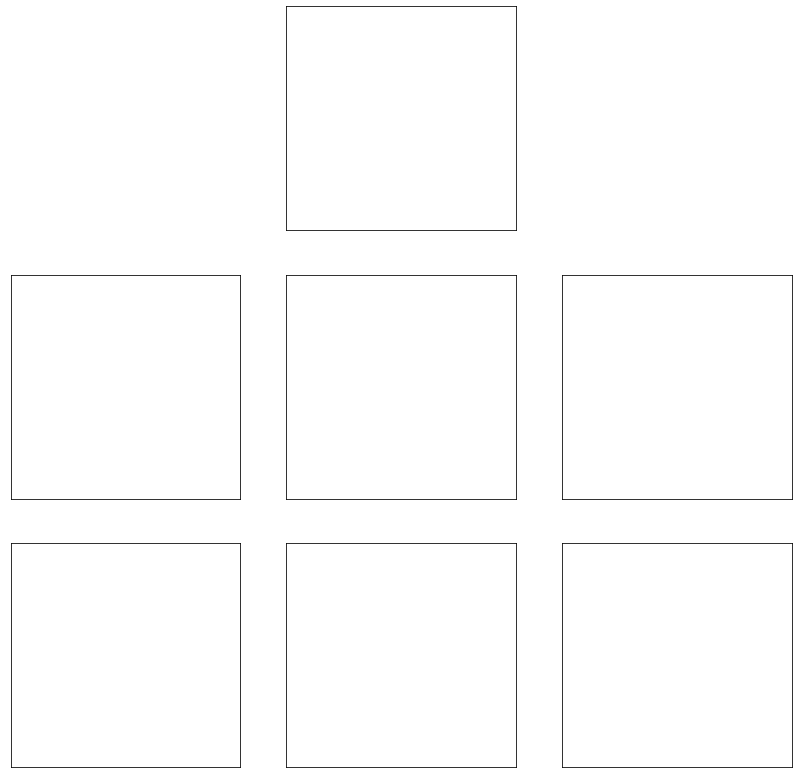

In [ ]:
plt.figure(figsize=(14,14))
plt.subplot(3,3,2)
plt.xticks([])
plt.yticks([])
ax=plt.gca()
plt.plot()
#plt.text(-2.4,0.2,"Suma de todas las intensidades \n en cada pixel.")
texts=["Suma de todas las intensidades \n superiores al percentil 75.","Suma de todas las intensidades \n superiores al percentil 85.","Suma de todas las intensidades \n superiores al percentil 99,9.",
       "Número de las incidencias de fotones \n superiores al percentil 75 de energías.","Número de las incidencias de fotones \n superiores al percentil 85 de energías.","Número de las incidencias de fotones \n superiores al percentil 99,9 de energías."]
for i in range(4,10):
  plt.subplot(3,3,i)
  plt.xticks([])
  plt.yticks([])
plt.savefig("blank_im.png")
  #plt.text(-0.4,0.2,texts[i-4])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 93, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 93, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 46, 64)        51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 46, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19136)             0

{'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 55, 93, 1),
    'dtype': 'float64',
    'name': 'conv2d_input',
    'ragged': False,
    'sparse': False}},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype': 'float32',
    'filters': 32,
    'groups': 1,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotNormal',
     'config': {'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (5, 5),
    'name': 'conv2d',
    'padding': 'same',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True}},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros